<a href="https://colab.research.google.com/github/ilyandho/FPL-Optimal-Transfer/blob/main/FPL_points_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12,9)

# Helper functions


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# For the linear model


def Linear_regression(features_train, features_test, target_train, target_test):
    # Before using our data, we need to do feature scaling and we opt for the 'standardization' method of scaling.
    # The 'standardization' is avaliable thorugh the StandardScaler() method
    # Transformers help in batching tasks in a pipepline. In this case, the data is scaled and then a linear regression model is fitted on the scaled data.
    # We use a transformer that takes the regression model and the transformation method
    # The TransformedTargetRegressor does the transformation and when we do the prediction, it automatically does the inverse transformation (scaling) and returns the values
    model = TransformedTargetRegressor(
        LinearRegression(), transformer=StandardScaler())

    # fit the transofrmer on the train data
    model.fit(features_train, target_train)

    # With the model fitted, we can predict the total_points given the feature_train and feature_test set
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    # Evaluate the performance of the model on both sets using the root mean square error
    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    # Get the score of the model or the coeeficient of determination i.e how much of the target value can be explained by the model.
    # In this case, 0.6 implies that 60% of the variations in the target value can be explained by the model and 40% is not explainable
    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # If the test error significantly differs from the train error, then there is either overfitting or underfitting
    # RMSE, just like the squared loss function that it derives from, effectively penalizes larger errors more severely.
    print('Training set RMSE: {}'.format(train_RMSE))
    print('Test set RMSE: {}'.format(test_RMSE))



    print('Training set R2: {}'.format(R2_train))
    print('Test set R2: {}'.format(R2_test))

    # Carry out cross validation of the model.
    # The evaluation method is the root mean square error
    # The method expects a utility function (greater is better) and so the scoring function is the opposite of the the RMSE. Hence the -ve
    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)

    print(pd.Series(tree_rmses).describe())

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


# Decision Tree Model
def DecisionTreeRegression(features_train, features_test, target_train, target_test):
    # The DecisionTreeRegressor is passed as the model to the TransformedTreeRegressor together with the StandardScaler
    model = TransformedTargetRegressor(
        DecisionTreeRegressor(), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    print('Training set RMSE: {}'.format(train_RMSE))
    print('Test set RMSE: {}'.format(test_RMSE))
    print('Training set R2: {}'.format(R2_train))
    print('Test set R2: {}'.format(R2_test))

    from sklearn.model_selection import cross_val_score

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)
    print(pd.Series(tree_rmses).describe())
    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


# RandomForestRegressor
def RandomForestRegression(features_train, features_test, target_train, target_test, hyperparameters):
    # RandomForestRegressor is an ensemble method
    # The TransformedTargetRegressor is passed the RandomForestRegressor model
    # The RandomForestRegressor is passed some hyper-parameters such as;
    # n_esimtaors: number of trees in the forest,
    # max_depth: the maximum depth of the tree,
    # criterion: the function to measure the quality of the split

    model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=hyperparameters['n_estimators'],  max_depth=hyperparameters['max_depth'], criterion=hyperparameters['criterion'], random_state=18), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # print('Training set RMSE: {}'.format(train_RMSE))
    # print('Test set RMSE: {}'.format(test_RMSE))
    # print('Training set R2: {}'.format(R2_train))
    # print('Test set R2: {}'.format(R2_test))

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)
    print(pd.Series(tree_rmses).describe())

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


def XGBoostRegression(features_train, features_test, target_train, target_test, hyperparameters):
    regressor = xgb(learning_rate=hyperparameters["learning_rate"],
                    n_estimators=hyperparameters["n_estimators"],
                    max_depth=hyperparameters["max_depth"],
                    eval_metric='rmsle')

    model = TransformedTargetRegressor(regressor, transformer=StandardScaler())


    model.fit(features_train, target_train)

    # =========================================================================
    # To use early_stopping_rounds:
    # "Validation metric needs to improve at least once in every
    # early_stopping_rounds round(s) to continue training."
    # =========================================================================
    # first perform a test/train split
    # from sklearn.model_selection import train_test_split

    # X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
    # model.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

    # =========================================================================
    # use the model to predict the prices for the test data
    # =========================================================================
    # predictions = model.predict(goalkeepers_splits['feature_test'])

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train,  pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # print('Training set RMSE: {}'.format(train_RMSE))
    # print('Test set RMSE: {}'.format(test_RMSE))
    # print('Training set R2: {}'.format(R2_train))
    # print('Test set R2: {}'.format(R2_test))

    tree_rmses = -cross_val_score(model, features_train, target_train, scoring="neg_root_mean_squared_error", cv=10)
    pd.Series(tree_rmses).describe()

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE,  'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


def GridSearchParams(features_train, target_train):
    # Instatiate the model
    model = RandomForestRegressor()

    param_grid = {'n_estimators': [8, 10, 12, 14, 16, 18, 20]}

    # Define the possible values of the hyperparameter
    grid = {
        'n_estimators': [8, 10, 12, 14, 16, 18, 20, 200, 300, 400, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'random_state': [18]
    }

    # Deine the model with cv=3 for a 3-fold cross validation
    # GridSearchCV has the best_estimator_ parameter that returns the  estimator
    # which gave highest score (or smallest loss if specified)

    grid_search = GridSearchCV(
        model, grid, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(features_train, target_train)

    # Get the best param combination
    print(grid_search.best_estimator_)

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'R2_train': R2_train, 'R2_test': R2_test}

In [4]:

# define a function that splits and returns features_train, features_test, target_train, target_test

def split_data(data):
    # Store the 'total_points' target in the 'player_target' variable
    # and the rest in the player_features variable
    player_target = data['total_points']
    player_features = data.drop("total_points", axis=1)

    # The train_test_split function splits the set into train and test sets while maintain the same data distribution over both sets.
    # It takes the feature and target sets and reutrns the respective train and test sets
    features_train, features_test, target_train, target_test = train_test_split(
        player_features, player_target, test_size=0.2)

    return {'feature_train': features_train, 'features_test': features_test, 'target_train': target_train, 'target_test': target_test}

# Data collection


In [6]:
df = pd.read_csv('./content/fpl_player_data_new.csv').drop(columns=['Unnamed: 0'])

In [7]:
# Separate the week to be predicted
##
def get_details(gw):
    # player_data = pd.DataFrame(get_player_data(gw))

    # Separate next gw's data
    next_gw_data = df[df['gw'] == gw]

    # Drop this data from the rest of data
    player_data = df.drop(df[df['gw'] >= gw].index)

    return player_data #, next_gw_data


details = get_details(39)
details.head()

,id,gw,team_h_difficulty,team_a_difficulty,position,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,in_dreamteam
0,1,1,2,5,4,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
1,2,1,2,5,2,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
2,3,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
3,4,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
4,5,1,2,5,2,4,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.02,1,False


In [8]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29679 entries, 0 to 29678
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29679 non-null  int64  
 1   gw                          29679 non-null  int64  
 2   team_h_difficulty           29679 non-null  int64  
 3   team_a_difficulty           29679 non-null  int64  
 4   position                    29679 non-null  int64  
 5   minutes                     29679 non-null  int64  
 6   goals_scored                29679 non-null  int64  
 7   assists                     29679 non-null  int64  
 8   clean_sheets                29679 non-null  int64  
 9   goals_conceded              29679 non-null  int64  
 10  own_goals                   29679 non-null  int64  
 11  penalties_saved             29679 non-null  int64  
 12  penalties_missed            29679 non-null  int64  
 13  yellow_cards                296

#Data pre-processing


In [9]:
player_data = details.copy()
# next_gw_data = details[1]
# Of the features, we want to use features that are available at the time the model is running.
# This makes sure that the model only depends on games stats that are available before the match starts.
# These will store in the 'attributes' variable and we will subsquently be using these for the rest of the work.
attributes = ['id','gw','team_h_difficulty', 'team_a_difficulty', 'position', 'minutes',  'goals_scored',
              'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
              'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
              'threat', 'ict_index', 'starts','expected_goals', 'expected_assists',
              'expected_goal_involvements', 'expected_goals_conceded', 'total_points']
player_data = player_data[attributes]
player_data

,id,gw,team_h_difficulty,team_a_difficulty,position,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points
0,1,1,2,5,4,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
1,2,1,2,5,2,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
2,3,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
3,4,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
4,5,1,2,5,2,4,0,0,0,0,...,0.2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29674,862,38,3,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29675,863,38,2,5,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29676,864,38,3,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29677,865,38,3,3,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0


In [10]:
def prev_3(feats, data): # create a feature that data in last 3 gws
  data = data.copy()
  data = data.sort_values(by=['id', 'gw'])  # Sort by ID and gameweek
  for feat in feats:
    data[feat+'_3'] = (
        data.groupby(['id'])[feat]
        .rolling(3, min_periods=1, closed='left').sum()).reset_index(level=0, drop=True).fillna(data[feat])
  return data

In [11]:
feats = ['starts','minutes',  'goals_scored',  'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
        'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity','threat']

y = prev_3(feats, player_data)
player_data_3 = y.drop(feats, axis=1)
player_data_3


,id,gw,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
0,1,1,2,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658,1,2,5,3,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1328,1,3,2,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,1,4,3,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2716,1,5,5,3,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29674,862,38,3,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29675,863,38,2,5,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29676,864,38,3,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29677,865,38,3,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
working_data = player_data_3.loc[player_data_3['gw'] < 35]
working_data = working_data.drop(['id','gw'], axis=1)

working_data

,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,starts_3,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
0,2,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658,5,3,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1328,2,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,3,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2716,5,3,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26230,2,2,3,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26231,2,4,2,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26232,2,2,1,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26233,2,3,2,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Split data by positions
df_gk = working_data.loc[working_data['position'] == 1].drop('position', axis='columns')
print(df_gk.shape)

df_def = working_data.loc[working_data['position'] == 2].drop('position', axis='columns')
print(df_def.shape)

df_mid = working_data.loc[working_data['position'] == 3].drop('position', axis='columns')
print(df_mid.shape)

df_for = working_data.loc[working_data['position'] == 4].drop('position', axis='columns')
print(df_for.shape)

(3013, 25)
(8487, 25)
(11338, 25)
(3397, 25)


# Baseline Model


## Goalkeepers


In [14]:
# Split the gk data into train and test sets
gk_splits = split_data(df_gk)

#### Linear Model


In [15]:

base_gk_lin_reg = Linear_regression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = pd.DataFrame({"base_gk_lin_reg": [base_gk_lin_reg['train_RMSE'], base_gk_lin_reg['test_RMSE'], base_gk_lin_reg['cv_rmse'], base_gk_lin_reg['R2_train'], base_gk_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

gk_evaluation_stats

Training set RMSE: 1.1834014497174072
Test set RMSE: 1.1418020411322067
Training set R2: 0.6111852578824806
Test set R2: 0.6021273579371904
count    10.000000
mean      1.221755
std       0.151415
min       1.024283
25%       1.102320
50%       1.209913
75%       1.370730
max       1.401664
dtype: float64


,base_gk_lin_reg
train_RMSE,1.183401
test_RMSE,1.141802
cv_rmse,1.221755
R2_train,0.611185
R2_test,0.602127


#### DecisionTree Model


In [16]:
base_gk_dt_reg = DecisionTreeRegression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_dt_reg = [base_gk_dt_reg['train_RMSE'], base_gk_dt_reg['test_RMSE'], base_gk_dt_reg['cv_rmse'], base_gk_dt_reg['R2_train'], base_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.03519678568643478
Test set RMSE: 1.5766768868233294
Training set R2: 0.9996560585351197
Test set R2: 0.24133884109221648
count    10.000000
mean      1.594381
std       0.163061
min       1.364946
25%       1.469248
50%       1.569136
75%       1.699392
max       1.892332
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg
train_RMSE,1.183401,0.035197
test_RMSE,1.141802,1.576677
cv_rmse,1.221755,1.594381
R2_train,0.611185,0.999656
R2_test,0.602127,0.241339


#### RandomForest Model


In [17]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_gk_rf_reg = RandomForestRegression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_rf_reg = [base_gk_rf_reg['train_RMSE'], base_gk_rf_reg['test_RMSE'], base_gk_rf_reg['cv_rmse'], base_gk_rf_reg['R2_train'], base_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.136218
std       0.191420
min       0.904538
25%       0.990562
50%       1.088073
75%       1.268713
max       1.467994
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg
train_RMSE,1.183401,0.035197,0.754935
test_RMSE,1.141802,1.576677,1.063390
cv_rmse,1.221755,1.594381,1.136218
R2_train,0.611185,0.999656,0.841767
R2_test,0.602127,0.241339,0.654898


#### XgBoost Model


In [18]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_gk_xgb_reg = XGBoostRegression(gk_splits['feature_train'], gk_splits['features_test'], gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_xgb_reg = [base_gk_xgb_reg['train_RMSE'], base_gk_xgb_reg['test_RMSE'], base_gk_xgb_reg['cv_rmse'], base_gk_xgb_reg['R2_train'], base_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643
test_RMSE,1.141802,1.576677,1.063390,1.088094
cv_rmse,1.221755,1.594381,1.136218,1.135801
R2_train,0.611185,0.999656,0.841767,0.768751
R2_test,0.602127,0.241339,0.654898,0.638677


## Defenders


In [19]:
# Split the gk data into train and test sets
def_splits = split_data(df_def)

#### Linear Model


In [20]:

base_def_lin_reg = Linear_regression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = pd.DataFrame({"base_def_lin_reg": [base_def_lin_reg['train_RMSE'], base_def_lin_reg['test_RMSE'], base_def_lin_reg['cv_rmse'], base_def_lin_reg['R2_train'], base_def_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

def_evaluation_stats

Training set RMSE: 1.5291962283425589
Test set RMSE: 1.541682177307876
Training set R2: 0.532247252424894
Test set R2: 0.4932893765861377
count    10.000000
mean      1.536195
std       0.140734
min       1.347684
25%       1.406271
50%       1.570267
75%       1.606342
max       1.742072
dtype: float64


,base_def_lin_reg
train_RMSE,1.529196
test_RMSE,1.541682
cv_rmse,1.536195
R2_train,0.532247
R2_test,0.493289


#### DecisionTree Model


In [21]:
base_def_dt_reg = DecisionTreeRegression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_dt_reg = [base_def_dt_reg['train_RMSE'], base_def_dt_reg['test_RMSE'], base_def_dt_reg['cv_rmse'], base_def_dt_reg['R2_train'], base_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.03980829331787691
Test set RMSE: 2.0890800334478556
Training set R2: 0.9996830162286254
Test set R2: 0.06957694634429101
count    10.000000
mean      2.072005
std       0.203664
min       1.761557
25%       1.929092
50%       2.088114
75%       2.186881
max       2.363817
dtype: float64


,base_def_lin_reg,base_def_dt_reg
train_RMSE,1.529196,0.039808
test_RMSE,1.541682,2.089080
cv_rmse,1.536195,2.072005
R2_train,0.532247,0.999683
R2_test,0.493289,0.069577


#### RandomForest Model


In [22]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_def_rf_reg = RandomForestRegression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_rf_reg = [base_def_rf_reg['train_RMSE'], base_def_rf_reg['test_RMSE'], base_def_rf_reg['cv_rmse'], base_def_rf_reg['R2_train'], base_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.537579
std       0.152897
min       1.324038
25%       1.397386
50%       1.541783
75%       1.689054
max       1.711026
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg
train_RMSE,1.529196,0.039808,1.141958
test_RMSE,1.541682,2.089080,1.467879
cv_rmse,1.536195,2.072005,1.537579
R2_train,0.532247,0.999683,0.739151
R2_test,0.493289,0.069577,0.540642


#### XgBoost Model


In [23]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_def_xgb_reg = XGBoostRegression(def_splits['feature_train'], def_splits['features_test'], def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_xgb_reg = [base_def_xgb_reg['train_RMSE'], base_def_xgb_reg['test_RMSE'], base_def_xgb_reg['cv_rmse'], base_def_xgb_reg['R2_train'], base_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996
test_RMSE,1.541682,2.089080,1.467879,1.443681
cv_rmse,1.536195,2.072005,1.537579,1.496858
R2_train,0.532247,0.999683,0.739151,0.638685
R2_test,0.493289,0.069577,0.540642,0.555662


## Midfielders


In [24]:
# Split the gk data into train and test sets
mid_splits = split_data(df_mid)

#### Linear Model


In [25]:

base_mid_lin_reg = Linear_regression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = pd.DataFrame({"base_mid_lin_reg": [base_mid_lin_reg['train_RMSE'], base_mid_lin_reg['test_RMSE'], base_mid_lin_reg['cv_rmse'], base_mid_lin_reg['R2_train'], base_mid_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

mid_evaluation_stats

Training set RMSE: 1.195767685457252
Test set RMSE: 1.2572234289035462
Training set R2: 0.7482951102400314
Test set R2: 0.7460110698507396
count    10.000000
mean      1.201918
std       0.089688
min       1.041471
25%       1.153187
50%       1.197759
75%       1.265456
max       1.338993
dtype: float64


,base_mid_lin_reg
train_RMSE,1.195768
test_RMSE,1.257223
cv_rmse,1.201918
R2_train,0.748295
R2_test,0.746011


#### DecisionTree Model


In [26]:
base_mid_dt_reg = DecisionTreeRegression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_dt_reg = [base_mid_dt_reg['train_RMSE'], base_mid_dt_reg['test_RMSE'], base_mid_dt_reg['cv_rmse'], base_mid_dt_reg['R2_train'], base_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.04474729267818661
Test set RMSE: 1.7239026758301117
Training set R2: 0.9996475223730469
Test set R2: 0.5224538535129015
count    10.000000
mean      1.581176
std       0.105530
min       1.421218
25%       1.508473
50%       1.579601
75%       1.654958
max       1.754502
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg
train_RMSE,1.195768,0.044747
test_RMSE,1.257223,1.723903
cv_rmse,1.201918,1.581176
R2_train,0.748295,0.999648
R2_test,0.746011,0.522454


#### RandomForest Model


In [27]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_mid_rf_reg = RandomForestRegression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_rf_reg = [base_mid_rf_reg['train_RMSE'], base_mid_rf_reg['test_RMSE'], base_mid_rf_reg['cv_rmse'], base_mid_rf_reg['R2_train'], base_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.148612
std       0.113721
min       0.986681
25%       1.072184
50%       1.155347
75%       1.193628
max       1.337439
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg
train_RMSE,1.195768,0.044747,0.835339
test_RMSE,1.257223,1.723903,1.203523
cv_rmse,1.201918,1.581176,1.148612
R2_train,0.748295,0.999648,0.877164
R2_test,0.746011,0.522454,0.767245


#### XgBoost Model


In [28]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_mid_xgb_reg = XGBoostRegression(mid_splits['feature_train'], mid_splits['features_test'], mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_xgb_reg = [base_mid_xgb_reg['train_RMSE'], base_mid_xgb_reg['test_RMSE'], base_mid_xgb_reg['cv_rmse'], base_mid_xgb_reg['R2_train'], base_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592
test_RMSE,1.257223,1.723903,1.203523,1.212620
cv_rmse,1.201918,1.581176,1.148612,1.147339
R2_train,0.748295,0.999648,0.877164,0.817359
R2_test,0.746011,0.522454,0.767245,0.763713


## Forwards


In [29]:
# Split the gk data into train and test sets
for_splits = split_data(df_for)

#### Linear Model


In [30]:

base_for_lin_reg = Linear_regression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = pd.DataFrame({"base_for_lin_reg": [base_for_lin_reg['train_RMSE'], base_for_lin_reg['test_RMSE'], base_for_lin_reg['cv_rmse'], base_for_lin_reg['R2_train'], base_for_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

for_evaluation_stats

Training set RMSE: 1.121624705359567
Test set RMSE: 1.2075657708259093
Training set R2: 0.8100092399581901
Test set R2: 0.7806361401870002
count    10.000000
mean      1.147317
std       0.166458
min       1.028552
25%       1.037606
50%       1.064840
75%       1.160368
max       1.508557
dtype: float64


,base_for_lin_reg
train_RMSE,1.121625
test_RMSE,1.207566
cv_rmse,1.147317
R2_train,0.810009
R2_test,0.780636


#### DecisionTree Model


In [31]:
base_for_dt_reg = DecisionTreeRegression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_dt_reg = [base_for_dt_reg['train_RMSE'], base_for_dt_reg['test_RMSE'], base_for_dt_reg['cv_rmse'], base_for_dt_reg['R2_train'], base_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.04060277034443405
Test set RMSE: 1.6951511971715207
Training set R2: 0.999751029047888
Test set R2: 0.5677247485010558
count    10.000000
mean      1.578892
std       0.351802
min       1.183530
25%       1.302737
50%       1.572503
75%       1.685523
max       2.313128
dtype: float64


,base_for_lin_reg,base_for_dt_reg
train_RMSE,1.121625,0.040603
test_RMSE,1.207566,1.695151
cv_rmse,1.147317,1.578892
R2_train,0.810009,0.999751
R2_test,0.780636,0.567725


#### RandomForest Model


In [32]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_for_rf_reg = RandomForestRegression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_rf_reg = [base_for_rf_reg['train_RMSE'], base_for_rf_reg['test_RMSE'], base_for_rf_reg['cv_rmse'], base_for_rf_reg['R2_train'], base_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.113292
std       0.179056
min       0.932186
25%       0.966761
50%       1.053408
75%       1.236698
max       1.438194
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg
train_RMSE,1.121625,0.040603,0.652528
test_RMSE,1.207566,1.695151,1.220518
cv_rmse,1.147317,1.578892,1.113292
R2_train,0.810009,0.999751,0.935696
R2_test,0.780636,0.567725,0.775905


#### XgBoost Model


In [33]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_for_xgb_reg = XGBoostRegression(for_splits['feature_train'], for_splits['features_test'], for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_xgb_reg = [base_for_xgb_reg['train_RMSE'], base_for_xgb_reg['test_RMSE'], base_for_xgb_reg['cv_rmse'], base_for_xgb_reg['R2_train'], base_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933
test_RMSE,1.207566,1.695151,1.220518,1.221652
cv_rmse,1.147317,1.578892,1.113292,1.115114
R2_train,0.810009,0.999751,0.935696,0.886758
R2_test,0.780636,0.567725,0.775905,0.775488


# Feature engineering


## Goalkeepers


### VarianceThreshold


In [34]:
VT_scaler = StandardScaler()
VT_scaler.fit(gk_splits['feature_train'])
df_gk_train_scaled = pd.DataFrame(VT_scaler.fit_transform(gk_splits['feature_train']), columns=gk_splits['feature_train'].columns)
df_gk_test_scaled = pd.DataFrame(VT_scaler.transform(gk_splits['features_test']), columns=gk_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_gk_train_scaled)

gk_threshold_columns = df_gk_train_scaled.columns[selector.get_support()]

gk_threshold_train = df_gk_train_scaled[gk_threshold_columns]
gk_threshold_test = df_gk_test_scaled[gk_threshold_columns]

gk_threshold_train.shape, gk_threshold_test.shape

((2410, 21), (603, 21))

#### Model(VT)


##### Linear Model


In [35]:

VarT_gk_lin_reg = Linear_regression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_lin_reg =  [VarT_gk_lin_reg['train_RMSE'], VarT_gk_lin_reg['test_RMSE'], VarT_gk_lin_reg['cv_rmse'], VarT_gk_lin_reg['R2_train'], VarT_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.1834014497174072
Test set RMSE: 1.1418020411322025
Training set R2: 0.6111852578824806
Test set R2: 0.6021273579371933
count    1.000000e+01
mean     8.094855e+10
std      2.559818e+11
min      1.031180e+00
25%      1.137232e+00
50%      1.315062e+00
75%      1.375593e+00
max      8.094855e+11
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01


##### DecisionTree Model


In [36]:
VarT_gk_dt_reg = DecisionTreeRegression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_dt_reg = [VarT_gk_dt_reg['train_RMSE'], VarT_gk_dt_reg['test_RMSE'], VarT_gk_dt_reg['cv_rmse'], VarT_gk_dt_reg['R2_train'], VarT_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.03519678568643478
Test set RMSE: 1.5302390122755172
Training set R2: 0.9996560585351197
Test set R2: 0.28537042206390717
count    10.000000
mean      1.554510
std       0.153718
min       1.380062
25%       1.458885
50%       1.515988
75%       1.590208
max       1.897806
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370


##### RandomForest Model


In [37]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_gk_rf_reg = RandomForestRegression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_rf_reg = [VarT_gk_rf_reg['train_RMSE'], VarT_gk_rf_reg['test_RMSE'], VarT_gk_rf_reg['cv_rmse'], VarT_gk_rf_reg['R2_train'], VarT_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.141478
std       0.196657
min       0.890198
25%       0.986910
50%       1.101302
75%       1.274493
max       1.489252
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516


##### XgBoost Model


In [38]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_gk_xgb_reg = XGBoostRegression(gk_threshold_train, gk_threshold_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_xgb_reg = [VarT_gk_xgb_reg['train_RMSE'], VarT_gk_xgb_reg['test_RMSE'], VarT_gk_xgb_reg['cv_rmse'], VarT_gk_xgb_reg['R2_train'], VarT_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677


### Feature selection techniques


#### K-best features


In [39]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(gk_threshold_train, gk_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, gk_splits['target_train'])

  k_sel_cols = gk_threshold_train.columns[selector.get_support()]
  k_sel_X_test = gk_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, gk_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.576, 0.648, 0.619, 0.648, 0.644, 0.638, 0.604, 0.607, 0.612, 0.611, 0.612, 0.6, 0.609, 0.594, 0.589, 0.625, 0.591, 0.597, 0.595, 0.601] 1


In [40]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat+1)
selector.fit_transform(gk_threshold_train, gk_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = gk_threshold_train[sel_feats]
k_sel_X_test = gk_threshold_test[sel_feats]

##### Model (KBest)


###### Linear Model


In [41]:

KBest_gk_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_lin_reg =  [KBest_gk_lin_reg['train_RMSE'], KBest_gk_lin_reg['test_RMSE'], KBest_gk_lin_reg['cv_rmse'], KBest_gk_lin_reg['R2_train'], KBest_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.257139901932893
Test set RMSE: 1.1850525440661832
Training set R2: 0.5612210833029312
Test set R2: 0.571414314566503
count    10.000000
mean      1.256091
std       0.160829
min       0.986586
25%       1.129442
50%       1.287040
75%       1.379480
max       1.450374
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414


###### DecisionTree Model


In [42]:
KBest_gk_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_dt_reg = [KBest_gk_dt_reg['train_RMSE'], KBest_gk_dt_reg['test_RMSE'], KBest_gk_dt_reg['cv_rmse'], KBest_gk_dt_reg['R2_train'], KBest_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.1358776250268436
Test set RMSE: 1.3889227905040895
Training set R2: 0.9948740493135162
Test set R2: 0.4112666253468107
count    10.000000
mean      1.579015
std       0.294345
min       1.171941
25%       1.448446
50%       1.545863
75%       1.705833
max       2.154798
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267


###### RandomForest Model


In [43]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_gk_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_rf_reg = [KBest_gk_rf_reg['train_RMSE'], KBest_gk_rf_reg['test_RMSE'], KBest_gk_rf_reg['cv_rmse'], KBest_gk_rf_reg['R2_train'], KBest_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.153805
std       0.216499
min       0.841048
25%       0.995568
50%       1.127494
75%       1.294484
max       1.539206
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878,0.817738
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923,1.139267
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015,1.153805
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874,0.814345
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267,0.603892


###### XgBoost Model


In [44]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_gk_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_xgb_reg = [KBest_gk_xgb_reg['train_RMSE'], KBest_gk_xgb_reg['test_RMSE'], KBest_gk_xgb_reg['cv_rmse'], KBest_gk_xgb_reg['R2_train'], KBest_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878,0.817738,0.972206
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923,1.139267,1.084134
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015,1.153805,1.134371
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874,0.814345,0.737581
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267,0.603892,0.641303


#### Mutual Information


In [45]:
from sklearn.feature_selection import mutual_info_regression
# gk_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, gk_splits['target_train'])
mutual_info

array([0.50712136, 0.47416188])

In [46]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

ict_index                  0.507121
expected_goals_conceded    0.474162
dtype: float64

<Axes: >

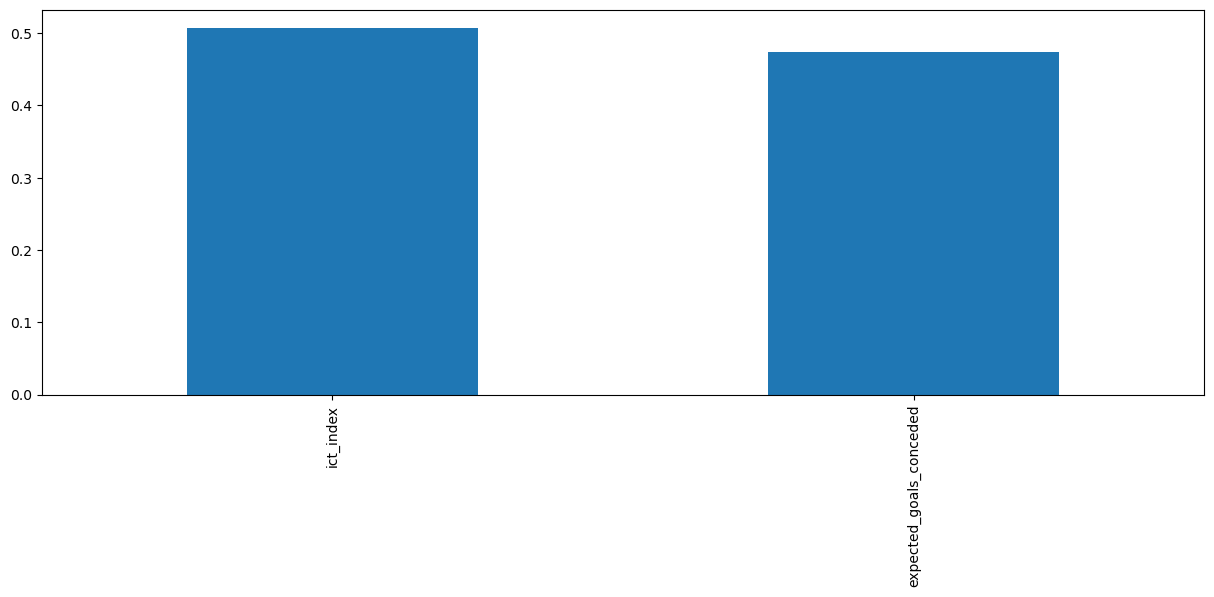

In [47]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct


In [48]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, gk_splits['target_train'])

selected_top_columns.get_support()

array([ True, False])

In [49]:
gk_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

gk_20_train = k_sel_X_train[gk_20_columns]
gk_20_test = k_sel_X_test[gk_20_columns]


In [50]:
gk_20_train.shape, gk_20_test.shape

((2410, 1), (603, 1))

##### Model (MI)


###### Linear Model


In [51]:

MI_gk_lin_reg = Linear_regression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_lin_reg =  [MI_gk_lin_reg['train_RMSE'], MI_gk_lin_reg['test_RMSE'], MI_gk_lin_reg['cv_rmse'], MI_gk_lin_reg['R2_train'], MI_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.2876393504858328
Test set RMSE: 1.2224162947762418
Training set R2: 0.5396724053031057
Test set R2: 0.5439623399830164
count    10.000000
mean      1.282464
std       0.169952
min       1.040078
25%       1.163945
50%       1.292896
75%       1.426823
max       1.505613
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878,0.817738,0.972206,1.287639
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923,1.139267,1.084134,1.222416
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015,1.153805,1.134371,1.282464
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874,0.814345,0.737581,0.539672
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267,0.603892,0.641303,0.543962


###### DecisionTree Model


In [52]:
MI_gk_dt_reg = DecisionTreeRegression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_dt_reg = [MI_gk_dt_reg['train_RMSE'], MI_gk_dt_reg['test_RMSE'], MI_gk_dt_reg['cv_rmse'], MI_gk_dt_reg['R2_train'], MI_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 1.103782382942706
Test set RMSE: 1.2100719909444169
Training set R2: 0.6617440493766437
Test set R2: 0.5531262287246346
count    10.000000
mean      1.296300
std       0.203581
min       1.071572
25%       1.117427
50%       1.270345
75%       1.461983
max       1.643891
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878,0.817738,0.972206,1.287639,1.103782
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923,1.139267,1.084134,1.222416,1.210072
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015,1.153805,1.134371,1.282464,1.296300
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874,0.814345,0.737581,0.539672,0.661744
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267,0.603892,0.641303,0.543962,0.553126


###### RandomForest Model


In [53]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_gk_rf_reg = RandomForestRegression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_rf_reg = [MI_gk_rf_reg['train_RMSE'], MI_gk_rf_reg['test_RMSE'], MI_gk_rf_reg['cv_rmse'], MI_gk_rf_reg['R2_train'], MI_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.251197
std       0.203409
min       0.995827
25%       1.082209
50%       1.226062
75%       1.381668
max       1.592824
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878,0.817738,0.972206,1.287639,1.103782,1.120007
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923,1.139267,1.084134,1.222416,1.210072,1.179119
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015,1.153805,1.134371,1.282464,1.296300,1.251197
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874,0.814345,0.737581,0.539672,0.661744,0.651727
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267,0.603892,0.641303,0.543962,0.553126,0.575695


###### XgBoost Model


In [54]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_gk_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_xgb_reg = [MI_gk_xgb_reg['train_RMSE'], MI_gk_xgb_reg['test_RMSE'], MI_gk_xgb_reg['cv_rmse'], MI_gk_xgb_reg['R2_train'], MI_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg,MI_gk_xgb_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878,0.817738,0.972206,1.287639,1.103782,1.120007,0.972206
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923,1.139267,1.084134,1.222416,1.210072,1.179119,1.084134
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015,1.153805,1.134371,1.282464,1.296300,1.251197,1.134371
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874,0.814345,0.737581,0.539672,0.661744,0.651727,0.737581
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267,0.603892,0.641303,0.543962,0.553126,0.575695,0.641303


## Defenders


### VarianceThreshold


In [55]:
VT_scaler = StandardScaler()
df_def_train_scaled = pd.DataFrame(VT_scaler.fit_transform(def_splits['feature_train']), columns=def_splits['feature_train'].columns)
df_def_test_scaled = pd.DataFrame(VT_scaler.transform(def_splits['features_test']), columns=def_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_def_train_scaled)

def_threshold_columns = df_def_train_scaled.columns[selector.get_support()]

def_threshold_train = df_def_train_scaled[def_threshold_columns]
def_threshold_test = df_def_test_scaled[def_threshold_columns]

def_threshold_train.shape, def_threshold_test.shape

((6789, 21), (1698, 21))

#### Model(VT)


##### Linear Model


In [56]:

VarT_def_lin_reg = Linear_regression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_lin_reg =  [VarT_def_lin_reg['train_RMSE'], VarT_def_lin_reg['test_RMSE'], VarT_def_lin_reg['cv_rmse'], VarT_def_lin_reg['R2_train'], VarT_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.5291962283425589
Test set RMSE: 1.5416821773078841
Training set R2: 0.532247252424894
Test set R2: 0.49328937658613226
count    10.000000
mean      1.536195
std       0.140734
min       1.347684
25%       1.406271
50%       1.570267
75%       1.606342
max       1.742072
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289


##### DecisionTree Model


In [57]:
VarT_def_dt_reg = DecisionTreeRegression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_dt_reg = [VarT_def_dt_reg['train_RMSE'], VarT_def_dt_reg['test_RMSE'], VarT_def_dt_reg['cv_rmse'], VarT_def_dt_reg['R2_train'], VarT_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.03980829331787691
Test set RMSE: 2.1159701399209814
Training set R2: 0.9996830162286254
Test set R2: 0.04547045468204125
count    10.000000
mean      2.110657
std       0.169338
min       1.890993
25%       1.957465
50%       2.086029
75%       2.240493
max       2.375006
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470


##### RandomForest Model


In [58]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_def_rf_reg = RandomForestRegression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_rf_reg = [VarT_def_rf_reg['train_RMSE'], VarT_def_rf_reg['test_RMSE'], VarT_def_rf_reg['cv_rmse'], VarT_def_rf_reg['R2_train'], VarT_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.537696
std       0.153607
min       1.326511
25%       1.398560
50%       1.542816
75%       1.688802
max       1.716309
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639


##### XgBoost Model


In [59]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_def_xgb_reg = XGBoostRegression(def_threshold_train, def_threshold_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_xgb_reg = [VarT_def_xgb_reg['train_RMSE'], VarT_def_xgb_reg['test_RMSE'], VarT_def_xgb_reg['cv_rmse'], VarT_def_xgb_reg['R2_train'], VarT_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662


### Feature selection techniques


#### K-best features


In [60]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(def_threshold_train, def_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, def_splits['target_train'])

  k_sel_cols = def_threshold_train.columns[selector.get_support()]
  k_sel_X_test = def_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, def_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.437, 0.527, 0.545, 0.552, 0.534, 0.543, 0.537, 0.539, 0.54, 0.528, 0.523, 0.52, 0.501, 0.5, 0.51, 0.519, 0.517, 0.511, 0.517, 0.518] 3


In [61]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat+1)
selector.fit_transform(def_threshold_train, def_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = def_threshold_train[sel_feats]
k_sel_X_test = def_threshold_test[sel_feats]

##### Model (KBest)


###### Linear Model


In [62]:

KBest_def_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_lin_reg =  [KBest_def_lin_reg['train_RMSE'], KBest_def_lin_reg['test_RMSE'], KBest_def_lin_reg['cv_rmse'], KBest_def_lin_reg['R2_train'], KBest_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.5512370002853204
Test set RMSE: 1.5492959626767544
Training set R2: 0.5186663536807729
Test set R2: 0.48827211355405453
count    10.000000
mean      1.548900
std       0.148242
min       1.386237
25%       1.403514
50%       1.582817
75%       1.598187
max       1.786641
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272


###### DecisionTree Model


In [63]:
KBest_def_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_dt_reg = [KBest_def_dt_reg['train_RMSE'], KBest_def_dt_reg['test_RMSE'], KBest_def_dt_reg['cv_rmse'], KBest_def_dt_reg['R2_train'], KBest_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.13734953218889812
Test set RMSE: 1.9222682832601958
Training set R2: 0.9962265006462284
Test set R2: 0.21223205197876116
count    10.000000
mean      2.095616
std       0.155120
min       1.964152
25%       1.970964
50%       2.002934
75%       2.248606
max       2.350841
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232


###### RandomForest Model


In [64]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_def_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_rf_reg = [KBest_def_rf_reg['train_RMSE'], KBest_def_rf_reg['test_RMSE'], KBest_def_rf_reg['cv_rmse'], KBest_def_rf_reg['R2_train'], KBest_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.523675
std       0.145675
min       1.354821
25%       1.379902
50%       1.514892
75%       1.675727
max       1.695784
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819


###### XgBoost Model


In [65]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_def_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_xgb_reg = [KBest_def_xgb_reg['train_RMSE'], KBest_def_xgb_reg['test_RMSE'], KBest_def_xgb_reg['cv_rmse'], KBest_def_xgb_reg['R2_train'], KBest_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530


#### Mutual Information


In [66]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, def_splits['target_train'])
mutual_info

array([0.5555929 , 0.26455907, 0.3199066 , 0.53430714])

In [67]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

ict_index                     0.555593
expected_goals_conceded       0.534307
expected_goal_involvements    0.319907
expected_assists              0.264559
dtype: float64

<Axes: >

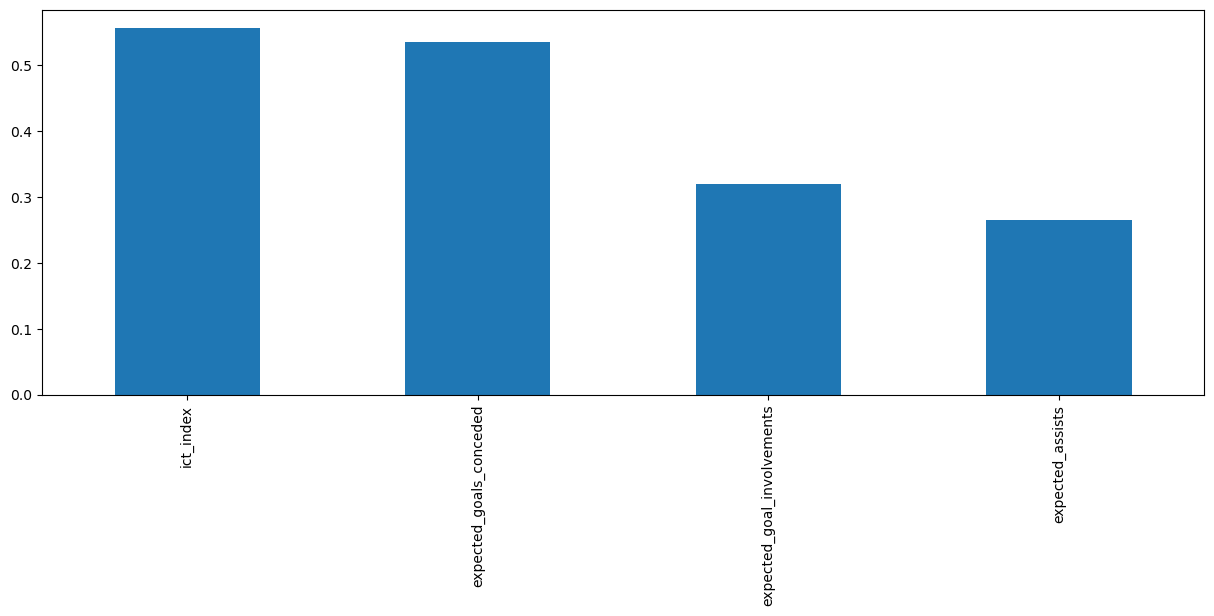

In [68]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct


In [69]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, def_splits['target_train'])

selected_top_columns.get_support()

array([ True, False, False,  True])

In [70]:
def_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

def_20_train = k_sel_X_train[def_20_columns]
def_20_test = k_sel_X_test[def_20_columns]


##### Model (MI)


###### Linear Model


In [71]:

MI_def_lin_reg = Linear_regression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_lin_reg =  [MI_def_lin_reg['train_RMSE'], MI_def_lin_reg['test_RMSE'], MI_def_lin_reg['cv_rmse'], MI_def_lin_reg['R2_train'], MI_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.5618056709474812
Test set RMSE: 1.559555332708039
Training set R2: 0.5120853012728876
Test set R2: 0.48147239481296045
count    10.000000
mean      1.556759
std       0.150416
min       1.389170
25%       1.405710
50%       1.586407
75%       1.621216
max       1.787924
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936,1.561806
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142,1.559555
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654,1.556759
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958,0.512085
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530,0.481472


###### DecisionTree Model


In [72]:
MI_def_dt_reg = DecisionTreeRegression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_dt_reg = [MI_def_dt_reg['train_RMSE'], MI_def_dt_reg['test_RMSE'], MI_def_dt_reg['cv_rmse'], MI_def_dt_reg['R2_train'], MI_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.3391357764573738
Test set RMSE: 2.008663880901
Training set R2: 0.9769942113704861
Test set R2: 0.1398289007506146
count    10.000000
mean      2.051155
std       0.215415
min       1.789255
25%       1.853746
50%       2.078936
75%       2.220415
max       2.362642
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936,1.561806,0.339136
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142,1.559555,2.008664
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654,1.556759,2.051155
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958,0.512085,0.976994
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530,0.481472,0.139829


###### RandomForest Model


In [73]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_def_rf_reg = RandomForestRegression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_rf_reg = [MI_def_rf_reg['train_RMSE'], MI_def_rf_reg['test_RMSE'], MI_def_rf_reg['cv_rmse'], MI_def_rf_reg['R2_train'], MI_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.524027
std       0.156495
min       1.295739
25%       1.372720
50%       1.562637
75%       1.647600
max       1.718652
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936,1.561806,0.339136,1.274768
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142,1.559555,2.008664,1.480649
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654,1.556759,2.051155,1.524027
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958,0.512085,0.976994,0.674948
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530,0.481472,0.139829,0.532615


###### XgBoost Model


In [74]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_def_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_xgb_reg = [MI_def_xgb_reg['train_RMSE'], MI_def_xgb_reg['test_RMSE'], MI_def_xgb_reg['cv_rmse'], MI_def_xgb_reg['R2_train'], MI_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936,1.561806,0.339136,1.274768,1.372936
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142,1.559555,2.008664,1.480649,1.447142
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654,1.556759,2.051155,1.524027,1.502654
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958,0.512085,0.976994,0.674948,0.622958
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530,0.481472,0.139829,0.532615,0.553530


## Midfielders


### VarianceThreshold


In [75]:
VT_scaler = StandardScaler()
df_mid_train_scaled = pd.DataFrame(VT_scaler.fit_transform(mid_splits['feature_train']), columns=mid_splits['feature_train'].columns)
df_mid_test_scaled = pd.DataFrame(VT_scaler.transform(mid_splits['features_test']), columns=mid_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_mid_train_scaled)

mid_threshold_columns = df_mid_train_scaled.columns[selector.get_support()]

mid_threshold_train = df_mid_train_scaled[mid_threshold_columns]
mid_threshold_test = df_mid_test_scaled[mid_threshold_columns]

mid_threshold_train.shape, mid_threshold_test.shape

((9070, 22), (2268, 22))

#### Model(VT)


##### Linear Model


In [76]:

VarT_mid_lin_reg = Linear_regression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_lin_reg =  [VarT_mid_lin_reg['train_RMSE'], VarT_mid_lin_reg['test_RMSE'], VarT_mid_lin_reg['cv_rmse'], VarT_mid_lin_reg['R2_train'], VarT_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.195767685457252
Test set RMSE: 1.2572234289035442
Training set R2: 0.7482951102400315
Test set R2: 0.7460110698507403
count    10.000000
mean      1.201918
std       0.089688
min       1.041471
25%       1.153187
50%       1.197759
75%       1.265456
max       1.338993
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011


##### DecisionTree Model


In [77]:
VarT_mid_dt_reg = DecisionTreeRegression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_dt_reg = [VarT_mid_dt_reg['train_RMSE'], VarT_mid_dt_reg['test_RMSE'], VarT_mid_dt_reg['cv_rmse'], VarT_mid_dt_reg['R2_train'], VarT_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.04474729267818661
Test set RMSE: 1.6890212599865642
Training set R2: 0.9996475223730469
Test set R2: 0.5415836597572294
count    10.000000
mean      1.587469
std       0.126462
min       1.411095
25%       1.488763
50%       1.591965
75%       1.666951
max       1.804990
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584


##### RandomForest Model


In [78]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_mid_rf_reg = RandomForestRegression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_rf_reg = [VarT_mid_rf_reg['train_RMSE'], VarT_mid_rf_reg['test_RMSE'], VarT_mid_rf_reg['cv_rmse'], VarT_mid_rf_reg['R2_train'], VarT_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.149261
std       0.112824
min       0.991785
25%       1.075751
50%       1.151321
75%       1.199929
max       1.329233
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675


##### XgBoost Model


In [79]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_mid_xgb_reg = XGBoostRegression(mid_threshold_train, mid_threshold_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_xgb_reg = [VarT_mid_xgb_reg['train_RMSE'], VarT_mid_xgb_reg['test_RMSE'], VarT_mid_xgb_reg['cv_rmse'], VarT_mid_xgb_reg['R2_train'], VarT_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713


### Feature selection techniques


#### K-best features


In [80]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(mid_threshold_train, mid_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, mid_splits['target_train'])

  k_sel_cols = mid_threshold_train.columns[selector.get_support()]
  k_sel_X_test = mid_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, mid_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.72, 0.722, 0.722, 0.765, 0.769, 0.759, 0.753, 0.75, 0.755, 0.758, 0.749, 0.734, 0.735, 0.741, 0.731, 0.741, 0.734, 0.735, 0.732, 0.735] 4


In [81]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat)
selector.fit_transform(mid_threshold_train, mid_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = mid_threshold_train[sel_feats]
k_sel_X_test = mid_threshold_test[sel_feats]

##### Model (KBest)


###### Linear Model


In [82]:

KBest_mid_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_lin_reg =  [KBest_mid_lin_reg['train_RMSE'], KBest_mid_lin_reg['test_RMSE'], KBest_mid_lin_reg['cv_rmse'], KBest_mid_lin_reg['R2_train'], KBest_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.201742733594728
Test set RMSE: 1.2655530712648806
Training set R2: 0.7457733723814187
Test set R2: 0.7426343503235108
count    10.000000
mean      1.201814
std       0.086511
min       1.039944
25%       1.159701
50%       1.203738
75%       1.267519
max       1.328199
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634


###### DecisionTree Model


In [83]:
KBest_mid_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_dt_reg = [KBest_mid_dt_reg['train_RMSE'], KBest_mid_dt_reg['test_RMSE'], KBest_mid_dt_reg['cv_rmse'], KBest_mid_dt_reg['R2_train'], KBest_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.09039938340053141
Test set RMSE: 1.7098625132327956
Training set R2: 0.9985614367439956
Test set R2: 0.5302008362500197
count    10.000000
mean      1.632142
std       0.117460
min       1.452656
25%       1.562458
50%       1.618748
75%       1.688264
max       1.856447
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201


###### RandomForest Model


In [84]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_mid_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_rf_reg = [KBest_mid_rf_reg['train_RMSE'], KBest_mid_rf_reg['test_RMSE'], KBest_mid_rf_reg['cv_rmse'], KBest_mid_rf_reg['R2_train'], KBest_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.159815
std       0.106190
min       0.996320
25%       1.101615
50%       1.181479
75%       1.213551
max       1.305926
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131


###### XgBoost Model


In [85]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_mid_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_xgb_reg = [KBest_mid_xgb_reg['train_RMSE'], KBest_mid_xgb_reg['test_RMSE'], KBest_mid_xgb_reg['cv_rmse'], KBest_mid_xgb_reg['R2_train'], KBest_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006,1.045517
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114,1.213248
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815,1.139067
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837,0.807575
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131,0.763469


#### Mutual Information


In [86]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, mid_splits['target_train'])
mutual_info

array([0.72865157, 0.43194485, 0.52768417, 0.61595052])

In [87]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

ict_index                     0.728652
expected_goals_conceded       0.615951
expected_goal_involvements    0.527684
expected_assists              0.431945
dtype: float64

<Axes: >

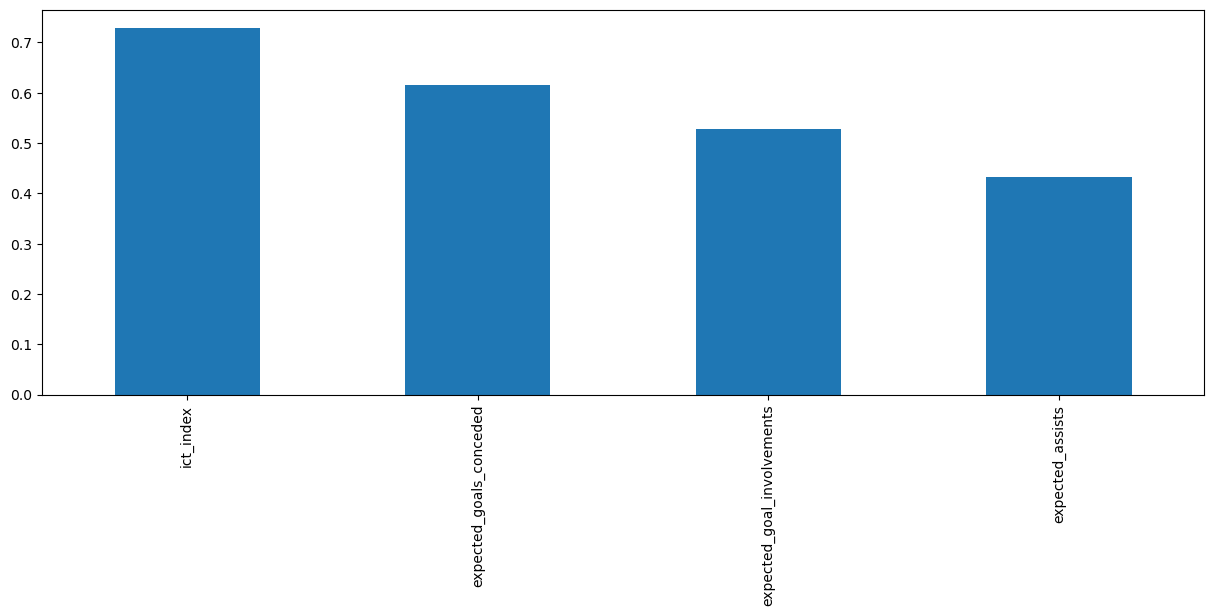

In [88]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct


In [89]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, mid_splits['target_train'])

selected_top_columns.get_support()

array([ True, False, False,  True])

In [90]:
mid_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

mid_20_train = k_sel_X_train[mid_20_columns]
mid_20_test = k_sel_X_test[mid_20_columns]


##### Model (MI)


###### Linear Model


In [91]:

MI_mid_lin_reg = Linear_regression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_lin_reg =  [MI_mid_lin_reg['train_RMSE'], MI_mid_lin_reg['test_RMSE'], MI_mid_lin_reg['cv_rmse'], MI_mid_lin_reg['R2_train'], MI_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.2344062041020873
Test set RMSE: 1.30672628400424
Training set R2: 0.7317657576057613
Test set R2: 0.7256157928447908
count    10.000000
mean      1.232410
std       0.097690
min       1.018821
25%       1.197378
50%       1.244614
75%       1.285928
max       1.372708
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006,1.045517,1.234406
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114,1.213248,1.306726
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815,1.139067,1.232410
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837,0.807575,0.731766
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131,0.763469,0.725616


###### DecisionTree Model


In [92]:
MI_mid_dt_reg = DecisionTreeRegression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_dt_reg = [MI_mid_dt_reg['train_RMSE'], MI_mid_dt_reg['test_RMSE'], MI_mid_dt_reg['cv_rmse'], MI_mid_dt_reg['R2_train'], MI_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.255222392337218
Test set RMSE: 1.743616969830155
Training set R2: 0.9885333758570625
Test set R2: 0.5114691075786898
count    10.000000
mean      1.625381
std       0.102496
min       1.459499
25%       1.557819
50%       1.625772
75%       1.683024
max       1.792862
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006,1.045517,1.234406,0.255222
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114,1.213248,1.306726,1.743617
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815,1.139067,1.232410,1.625381
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837,0.807575,0.731766,0.988533
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131,0.763469,0.725616,0.511469


###### RandomForest Model


In [93]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_mid_rf_reg = RandomForestRegression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_rf_reg = [MI_mid_rf_reg['train_RMSE'], MI_mid_rf_reg['test_RMSE'], MI_mid_rf_reg['cv_rmse'], MI_mid_rf_reg['R2_train'], MI_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.213803
std       0.096781
min       1.025246
25%       1.193989
50%       1.230528
75%       1.253751
max       1.382777
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006,1.045517,1.234406,0.255222,1.001407
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114,1.213248,1.306726,1.743617,1.323912
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815,1.139067,1.232410,1.625381,1.213803
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837,0.807575,0.731766,0.988533,0.823470
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131,0.763469,0.725616,0.511469,0.718351


###### XgBoost Model


In [94]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_mid_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_xgb_reg = [MI_mid_xgb_reg['train_RMSE'], MI_mid_xgb_reg['test_RMSE'], MI_mid_xgb_reg['cv_rmse'], MI_mid_xgb_reg['R2_train'], MI_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg,MI_mid_xgb_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006,1.045517,1.234406,0.255222,1.001407,1.045517
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114,1.213248,1.306726,1.743617,1.323912,1.213248
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815,1.139067,1.232410,1.625381,1.213803,1.139067
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837,0.807575,0.731766,0.988533,0.823470,0.807575
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131,0.763469,0.725616,0.511469,0.718351,0.763469


## Forwards


### VarianceThreshold


In [95]:
VT_scaler = StandardScaler()
df_for_train_scaled = pd.DataFrame(VT_scaler.fit_transform(for_splits['feature_train']), columns=for_splits['feature_train'].columns)
df_for_test_scaled = pd.DataFrame(VT_scaler.transform(for_splits['features_test']), columns=for_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_for_train_scaled)

for_threshold_columns = df_for_train_scaled.columns[selector.get_support()]

for_threshold_train = df_for_train_scaled[for_threshold_columns]
for_threshold_test = df_for_test_scaled[for_threshold_columns]

for_threshold_train.shape, for_threshold_test.shape

((2717, 21), (680, 21))

#### Model(VT)


##### Linear Model


In [96]:

VarT_for_lin_reg = Linear_regression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_lin_reg =  [VarT_for_lin_reg['train_RMSE'], VarT_for_lin_reg['test_RMSE'], VarT_for_lin_reg['cv_rmse'], VarT_for_lin_reg['R2_train'], VarT_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.121624705359567
Test set RMSE: 1.2075657708259275
Training set R2: 0.8100092399581901
Test set R2: 0.7806361401869937
count    10.000000
mean      1.147317
std       0.166458
min       1.028552
25%       1.037606
50%       1.064840
75%       1.160368
max       1.508557
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636


##### DecisionTree Model


In [97]:
VarT_for_dt_reg = DecisionTreeRegression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_dt_reg = [VarT_for_dt_reg['train_RMSE'], VarT_for_dt_reg['test_RMSE'], VarT_for_dt_reg['cv_rmse'], VarT_for_dt_reg['R2_train'], VarT_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.04060277034443405
Test set RMSE: 1.6759569501986316
Training set R2: 0.999751029047888
Test set R2: 0.5774586568897524
count    10.000000
mean      1.542577
std       0.269819
min       1.217220
25%       1.337148
50%       1.430743
75%       1.737584
max       1.985236
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459


##### RandomForest Model


In [98]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_for_rf_reg = RandomForestRegression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_rf_reg = [VarT_for_rf_reg['train_RMSE'], VarT_for_rf_reg['test_RMSE'], VarT_for_rf_reg['cv_rmse'], VarT_for_rf_reg['R2_train'], VarT_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.111716
std       0.180839
min       0.934967
25%       0.965915
50%       1.044107
75%       1.222570
max       1.451842
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455


##### XgBoost Model


In [99]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_for_xgb_reg = XGBoostRegression(for_threshold_train, for_threshold_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_xgb_reg = [VarT_for_xgb_reg['train_RMSE'], VarT_for_xgb_reg['test_RMSE'], VarT_for_xgb_reg['cv_rmse'], VarT_for_xgb_reg['R2_train'], VarT_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488


### Feature selection techniques


#### K-best features


In [117]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(for_threshold_train, for_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, for_splits['target_train'])

  k_sel_cols = for_threshold_train.columns[selector.get_support()]
  k_sel_X_test = for_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, for_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.775, 0.781, 0.733, 0.762, 0.777, 0.778, 0.745, 0.727, 0.759, 0.757, 0.746, 0.733, 0.753, 0.754, 0.76, 0.711, 0.763, 0.741, 0.749, 0.727] 1


In [118]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat+1)
selector.fit_transform(for_threshold_train, for_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = for_threshold_train[sel_feats]
k_sel_X_test = for_threshold_test[sel_feats]

##### Model (KBest)


###### Linear Model


In [119]:

KBest_for_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_lin_reg =  [KBest_for_lin_reg['train_RMSE'], KBest_for_lin_reg['test_RMSE'], KBest_for_lin_reg['cv_rmse'], KBest_for_lin_reg['R2_train'], KBest_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.1487391233870219
Test set RMSE: 1.2102339869121403
Training set R2: 0.8007124484146315
Test set R2: 0.7796656641447247
count    10.000000
mean      1.147058
std       0.149972
min       1.010936
25%       1.067277
50%       1.103053
75%       1.132239
max       1.507537
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.889425,0.951872,1.036081
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.309705,1.222512,1.227271
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.292484,1.190290,1.161058
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.880531,0.863166,0.837884
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.741958,0.775172,0.773419


###### DecisionTree Model


In [120]:
KBest_for_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_dt_reg = [KBest_for_dt_reg['train_RMSE'], KBest_for_dt_reg['test_RMSE'], KBest_for_dt_reg['cv_rmse'], KBest_for_dt_reg['R2_train'], KBest_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.13830112374289377
Test set RMSE: 1.5165984593445927
Training set R2: 0.9971113909697729
Test set R2: 0.6539931380837969
count    10.000000
mean      1.570754
std       0.216660
min       1.242850
25%       1.428338
50%       1.593180
75%       1.734126
max       1.839613
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.951872,1.036081
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.222512,1.227271
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.190290,1.161058
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.863166,0.837884
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.775172,0.773419


###### RandomForest Model


In [121]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_for_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_rf_reg = [KBest_for_rf_reg['train_RMSE'], KBest_for_rf_reg['test_RMSE'], KBest_for_rf_reg['cv_rmse'], KBest_for_rf_reg['R2_train'], KBest_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.187193
std       0.182039
min       0.905339
25%       1.080036
50%       1.155707
75%       1.269465
max       1.547954
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,1.036081
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.227271
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.161058
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.837884
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.773419


###### XgBoost Model


In [122]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_for_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_xgb_reg = [KBest_for_xgb_reg['train_RMSE'], KBest_for_xgb_reg['test_RMSE'], KBest_for_xgb_reg['cv_rmse'], KBest_for_xgb_reg['R2_train'], KBest_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,0.979669
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.269802
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.143553
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.855057
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.757442


#### Mutual Information


In [132]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, for_splits['target_train'])
mutual_info

array([0.72273113, 0.56915407])

In [133]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

ict_index                  0.722731
expected_goals_conceded    0.569154
dtype: float64

<Axes: >

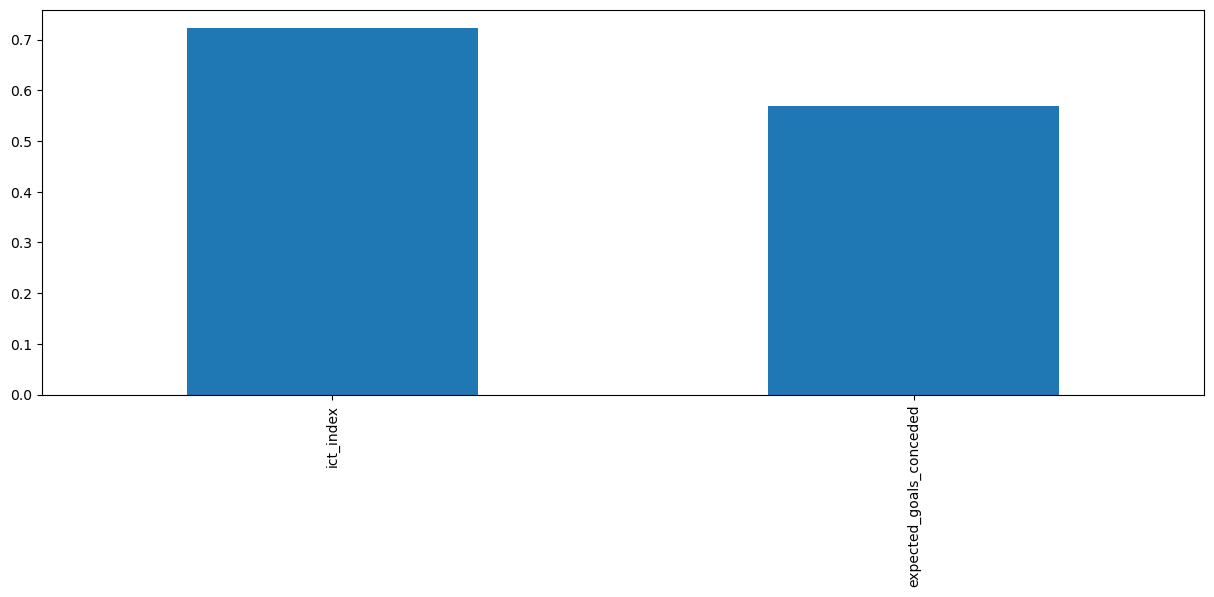

In [134]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct


In [135]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, for_splits['target_train'])

selected_top_columns.get_support()

array([ True, False])

In [136]:
for_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

for_20_train = k_sel_X_train[for_20_columns]
for_20_test = k_sel_X_test[for_20_columns]


##### Model (MI)


###### Linear Model


In [137]:

MI_for_lin_reg = Linear_regression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_lin_reg =  [MI_for_lin_reg['train_RMSE'], MI_for_lin_reg['test_RMSE'], MI_for_lin_reg['cv_rmse'], MI_for_lin_reg['R2_train'], MI_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.1487820907204103
Test set RMSE: 1.2107187134873412
Training set R2: 0.8006975398690149
Test set R2: 0.7794891308503618
count    10.000000
mean      1.145309
std       0.150373
min       1.004909
25%       1.065451
50%       1.102975
75%       1.129601
max       1.507161
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,0.979669,1.148782,0.889425,0.951872,0.979669
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.269802,1.210719,1.309705,1.222512,1.269802
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.143553,1.145309,1.292484,1.190290,1.143553
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.855057,0.800698,0.880531,0.863166,0.855057
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.757442,0.779489,0.741958,0.775172,0.757442


###### DecisionTree Model


In [138]:
MI_for_dt_reg = DecisionTreeRegression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_dt_reg = [MI_for_dt_reg['train_RMSE'], MI_for_dt_reg['test_RMSE'], MI_for_dt_reg['cv_rmse'], MI_for_dt_reg['R2_train'], MI_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.8894249172264307
Test set RMSE: 1.3097046311303446
Training set R2: 0.8805308067967568
Test set R2: 0.7419581082448692


count    10.000000
mean      1.292484
std       0.181366
min       1.064624
25%       1.128000
50%       1.318284
75%       1.401294
max       1.612792
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,0.979669,1.148782,0.889425,0.951872,0.979669
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.269802,1.210719,1.309705,1.222512,1.269802
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.143553,1.145309,1.292484,1.190290,1.143553
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.855057,0.800698,0.880531,0.863166,0.855057
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.757442,0.779489,0.741958,0.775172,0.757442


###### RandomForest Model


In [139]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_for_rf_reg = RandomForestRegression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_rf_reg = [MI_for_rf_reg['train_RMSE'], MI_for_rf_reg['test_RMSE'], MI_for_rf_reg['cv_rmse'], MI_for_rf_reg['R2_train'], MI_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.190290
std       0.179746
min       0.891451
25%       1.093982
50%       1.195415
75%       1.268931
max       1.555690
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,0.979669,1.148782,0.889425,0.951872,0.979669
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.269802,1.210719,1.309705,1.222512,1.269802
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.143553,1.145309,1.292484,1.190290,1.143553
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.855057,0.800698,0.880531,0.863166,0.855057
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.757442,0.779489,0.741958,0.775172,0.757442


###### XgBoost Model


In [140]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_for_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_xgb_reg = [MI_for_xgb_reg['train_RMSE'], MI_for_xgb_reg['test_RMSE'], MI_for_xgb_reg['cv_rmse'], MI_for_xgb_reg['R2_train'], MI_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,0.979669,1.148782,0.889425,0.951872,0.979669
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.269802,1.210719,1.309705,1.222512,1.269802
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.143553,1.145309,1.292484,1.190290,1.143553
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.855057,0.800698,0.880531,0.863166,0.855057
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.757442,0.779489,0.741958,0.775172,0.757442


# Best Stats


In [141]:
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg,MI_gk_xgb_reg
train_RMSE,1.183401,0.035197,0.754935,0.912643,1.183401e+00,0.035197,0.759926,0.912643,1.257140,0.135878,0.817738,0.972206,1.287639,1.103782,1.120007,0.972206
test_RMSE,1.141802,1.576677,1.063390,1.088094,1.141802e+00,1.530239,1.057801,1.088094,1.185053,1.388923,1.139267,1.084134,1.222416,1.210072,1.179119,1.084134
cv_rmse,1.221755,1.594381,1.136218,1.135801,8.094855e+10,1.554510,1.141478,1.135801,1.256091,1.579015,1.153805,1.134371,1.282464,1.296300,1.251197,1.134371
R2_train,0.611185,0.999656,0.841767,0.768751,6.111853e-01,0.999656,0.839667,0.768751,0.561221,0.994874,0.814345,0.737581,0.539672,0.661744,0.651727,0.737581
R2_test,0.602127,0.241339,0.654898,0.638677,6.021274e-01,0.285370,0.658516,0.638677,0.571414,0.411267,0.603892,0.641303,0.543962,0.553126,0.575695,0.641303


In [142]:
# Goalkeepers
#### XgBoost Model under the Variance threshold performed better


In [143]:
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936,1.561806,0.339136,1.274768,1.372936
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142,1.559555,2.008664,1.480649,1.447142
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654,1.556759,2.051155,1.524027,1.502654
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958,0.512085,0.976994,0.674948,0.622958
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530,0.481472,0.139829,0.532615,0.553530


In [144]:
# Defenders
#### Rf Model under the Variance threshold performed better

In [145]:
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg,MI_mid_xgb_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006,1.045517,1.234406,0.255222,1.001407,1.045517
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114,1.213248,1.306726,1.743617,1.323912,1.213248
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815,1.139067,1.232410,1.625381,1.213803,1.139067
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837,0.807575,0.731766,0.988533,0.823470,0.807575
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131,0.763469,0.725616,0.511469,0.718351,0.763469


In [146]:
# Midfielders
#### xgb Model under the MI performed better

In [147]:
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,0.979669,1.148782,0.889425,0.951872,0.979669
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.269802,1.210719,1.309705,1.222512,1.269802
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.143553,1.145309,1.292484,1.190290,1.143553
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.855057,0.800698,0.880531,0.863166,0.855057
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.757442,0.779489,0.741958,0.775172,0.757442


In [148]:
# Forwards
#### RF Model under the KBest performed better


## Fine tuning the models


### XgBoost (Goalkeepers and Midfielders)


In [149]:

from sklearn.model_selection import GridSearchCV
import numpy as np

# =========================================================================
# XGBoost regression:
# Parameters:
# n_estimators  "Number of gradient boosted trees. Equivalent to number
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make
#                the model more complex and more likely to overfit."
# =========================================================================
regressor = xgb(eval_metric='rmsle')

# =========================================================================
# exhaustively search for the optimal hyperparameters
# =========================================================================
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": np.arange(100, 1000, 50),
              "learning_rate": np.arange(0.01, .2, 0.005)}


In [151]:
# try out every combination of the above values
goalkeepers_search = GridSearchCV(regressor, param_grid, cv=5).fit(
    gk_threshold_train, gk_splits['target_train'])

print("The best hyperparameters are ", goalkeepers_search.best_params_)

The best hyperparameters are  {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 100}


In [152]:
# Deine the model with cv=5 for a 5-fold cross validation
# GridSearchCV has the best_estimator_ parameter that returns the  estimator
# which gave highest score (or smallest loss if specified)

mid_grid_search = GridSearchCV(regressor, param_grid, cv=5).fit(mid_20_train, mid_splits['target_train'])


print("The best midfielder hyperparameters are ", mid_grid_search.best_params_)

The best midfielder hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 350}


In [153]:
model = RandomForestRegressor()

param_grid = {'n_estimators': [8, 10, 12, 14, 16, 18, 20]}

# Define the possible values of the hyperparameter
grid = {
    'n_estimators': [8, 10, 12, 14, 16, 18, 20, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_state': [18]
}

In [154]:
def_grid_search = GridSearchCV(model, grid, cv=5,
                              scoring='neg_root_mean_squared_error')
def_grid_search.fit(def_threshold_train, def_splits['target_train'])

print("The best defender hyperparameters are ", def_grid_search.best_params_)

c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
550 fits failed out of a total of 2200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
550 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\

The best defender hyperparameters are  {'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 18}


In [155]:

forwards_search = GridSearchCV(model, grid, cv=5,
                              scoring='neg_root_mean_squared_error').fit(
    k_sel_X_train, for_splits['target_train'])


print("The best midfielder hyperparameters are ", forwards_search.best_params_)

c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
550 fits failed out of a total of 2200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
550 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\

The best midfielder hyperparameters are  {'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 18}


## With the hyperparameters


### Goalkeepers


In [160]:
hyperparameters = {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 100}
FT_gk_xgb_reg = XGBoostRegression(gk_threshold_train, gk_threshold_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(FT_gk_xgb_reg = [FT_gk_xgb_reg['train_RMSE'], FT_gk_xgb_reg['test_RMSE'], FT_gk_xgb_reg['cv_rmse'], FT_gk_xgb_reg['R2_train'], FT_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg,FT_def_rf_reg,FT_gk_xgb_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936,1.561806,0.339136,1.274768,1.372936,1.120973,0.910307
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142,1.559555,2.008664,1.480649,1.447142,1.446891,1.085887
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654,1.556759,2.051155,1.524027,1.502654,1.512877,1.135611
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958,0.512085,0.976994,0.674948,0.622958,0.748649,0.769933
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530,0.481472,0.139829,0.532615,0.553530,0.553684,0.640142


### Defenders


In [158]:
hyperparameters = {'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 18}
FT_def_rf_reg = RandomForestRegression(def_threshold_train, def_threshold_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(FT_def_rf_reg = [FT_def_rf_reg['train_RMSE'], FT_def_rf_reg['test_RMSE'], FT_def_rf_reg['cv_rmse'], FT_def_rf_reg['R2_train'], FT_def_rf_reg['R2_test']])
def_evaluation_stats

count    10.000000
mean      1.512877
std       0.150032
min       1.299504
25%       1.383093
50%       1.515509
75%       1.656350
max       1.689785
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg,FT_def_rf_reg
train_RMSE,1.529196,0.039808,1.141958,1.343996,1.529196,0.039808,1.141175,1.343996,1.551237,0.137350,1.207874,1.372936,1.561806,0.339136,1.274768,1.372936,1.120973
test_RMSE,1.541682,2.089080,1.467879,1.443681,1.541682,2.115970,1.472670,1.443681,1.549296,1.922268,1.423796,1.447142,1.559555,2.008664,1.480649,1.447142,1.446891
cv_rmse,1.536195,2.072005,1.537579,1.496858,1.536195,2.110657,1.537696,1.496858,1.548900,2.095616,1.523675,1.502654,1.556759,2.051155,1.524027,1.502654,1.512877
R2_train,0.532247,0.999683,0.739151,0.638685,0.532247,0.999683,0.739508,0.638685,0.518666,0.996227,0.708168,0.622958,0.512085,0.976994,0.674948,0.622958,0.748649
R2_test,0.493289,0.069577,0.540642,0.555662,0.493289,0.045470,0.537639,0.555662,0.488272,0.212232,0.567819,0.553530,0.481472,0.139829,0.532615,0.553530,0.553684


### Midfielders


In [159]:
hyperparameters = {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 350}
FT_mid_xgb_reg = XGBoostRegression(mid_20_train, mid_20_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(FT_mid_xgb_reg = [FT_mid_xgb_reg['train_RMSE'], FT_mid_xgb_reg['test_RMSE'], FT_mid_xgb_reg['cv_rmse'], FT_mid_xgb_reg['R2_train'], FT_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg,MI_mid_xgb_reg,FT_mid_xgb_reg
train_RMSE,1.195768,0.044747,0.835339,1.018592,1.195768,0.044747,0.835838,1.018592,1.201743,0.090399,0.873006,1.045517,1.234406,0.255222,1.001407,1.045517,0.996938
test_RMSE,1.257223,1.723903,1.203523,1.212620,1.257223,1.689021,1.207576,1.212620,1.265553,1.709863,1.214114,1.213248,1.306726,1.743617,1.323912,1.213248,1.210024
cv_rmse,1.201918,1.581176,1.148612,1.147339,1.201918,1.587469,1.149261,1.147339,1.201814,1.632142,1.159815,1.139067,1.232410,1.625381,1.213803,1.139067,1.142954
R2_train,0.748295,0.999648,0.877164,0.817359,0.748295,0.999648,0.877018,0.817359,0.745773,0.998561,0.865837,0.807575,0.731766,0.988533,0.823470,0.807575,0.825042
R2_test,0.746011,0.522454,0.767245,0.763713,0.746011,0.541584,0.765675,0.763713,0.742634,0.530201,0.763131,0.763469,0.725616,0.511469,0.718351,0.763469,0.764724


### Forwards


In [161]:
hyperparameters = {'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 18}
FT_for_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(FT_for_rf_reg = [FT_for_rf_reg['train_RMSE'], FT_for_rf_reg['test_RMSE'], FT_for_rf_reg['cv_rmse'], FT_for_rf_reg['R2_train'], FT_for_rf_reg['R2_test']])
for_evaluation_stats

count    10.000000
mean      1.157207
std       0.170589
min       0.920754
25%       1.020331
50%       1.130960
75%       1.267558
max       1.469881
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg,FT_for_rf_reg
train_RMSE,1.121625,0.040603,0.652528,0.865933,1.121625,0.040603,0.654492,0.865933,1.148739,0.138301,0.775923,0.979669,1.148782,0.889425,0.951872,0.979669,0.840542
test_RMSE,1.207566,1.695151,1.220518,1.221652,1.207566,1.675957,1.213555,1.221652,1.210234,1.516598,1.262968,1.269802,1.210719,1.309705,1.222512,1.269802,1.216678
cv_rmse,1.147317,1.578892,1.113292,1.115114,1.147317,1.542577,1.111716,1.115114,1.147058,1.570754,1.187193,1.143553,1.145309,1.292484,1.190290,1.143553,1.157207
R2_train,0.810009,0.999751,0.935696,0.886758,0.810009,0.999751,0.935309,0.886758,0.800712,0.997111,0.909077,0.855057,0.800698,0.880531,0.863166,0.855057,0.893302
R2_test,0.780636,0.567725,0.775905,0.775488,0.780636,0.577459,0.778455,0.775488,0.779666,0.653993,0.760046,0.757442,0.779489,0.741958,0.775172,0.757442,0.777313
